In [2]:
# Packages Used
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, date_format, mean, approx_count_distinct, corr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
from pathlib import Path
import os
import pyspark.sql.functions as F


In [3]:
import sys
sys.path.append("/home/emmmanuel/BDA/Ass_2/")
import mob_data_utils as ut

# Mobility Data Analysis
1. Scoping
2.  Preprocress the data
3. Explolatory Data Analysis (EDA)
4. Generate user trips and other user attributes
5. Perfom analysis of user data to generate individual level metrics
6. Generate aggregate metrics such as OD

# Project Scoping

#  Python setup
Heree, we import all the required Python packages. In order to use,
any other module which wasnt ```pip``` installed, such as ```mob_data_utils```,
you  can do the following:
```sys.append(full_path_to_module)```

# Setup working directories
Its also important to setup commonly used diretories such as where you will be saving data

In [4]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}

## Task-1. Data preprocessing and clean up.

# Data preprocessing.
Often, after all the data has been  acquired, thee next step is to do some preprocessing on the raw data.
The objectives of this task will vary depending on the data analysis goals but some of them include following:
- **Sanitize the data:** this data cleaning has to be done carefully to avoid introducing errors but its often a necessary step. It can involve dropping some unnecessary variables/columns. Renaming some columns to something which makes more sense. Dropping some observations. For instance, in this analysis where location and time-stamp is important, dropping all observations with no time-stamp and no location is required.
- **Create new variables:**. If necessary, this is also the time transform some variables from a format which is not convinient for your analysis. For instance, converting string time variables to datetime aware variables.
- **Combine datasets:** If you have more than one dataset, during preprocessing, you can also combine several datasets into one. For instance, we have the CDR transations which have no location details. We bring in the location details from another file.
- **Filtering based on columns and observations:** This can be done through any of the stages mentioned above but its worth mentioning that often, you may drop some columns which arent useful for your analysis. Also, you may drop some observations based on some conditions depending on your analysis needs.

Unlike in other data collection domains such as surveys where you can have standard data processing steps, in the data science space where your dataset can be anything, there are no hard and fast rule for preprocessing and data cleaning. It will be a case by case basis depending on your analysis goals. Also, preprocessing isnt necessarily a linear process: depending on what results you get downstream, you can go back and modify the preprocesisng steps. In this project, we have the ```preprocess_cdrs_using_spark``` which takes raw cdrs and saves to a CSV a processed dataset. Alternatively, we can return a Spark DataFrame.

In [5]:
def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='yyyyMMddHHmmss',
                                debug_mode=True, loc_file=None, save_to_csv=False):
    """
    Processes CDR data using Spark, handling data loading, transformation, and filtering.

    Args:
        file_or_folder (str, optional): Path to the input CDR files. Defaults to None.
        number_of_users_to_sample (int, optional): Number of users to randomly sample. Defaults to None.
        output_csv (str, optional): Path to save the processed DataFrame as a CSV file. Defaults to None.
        date_format (str, optional): Format of the datetime column. Defaults to 'yyyyMMddHHmmss'.
        debug_mode (bool, optional): If True, processes a smaller sample for testing. Defaults to True.
        loc_file (str, optional): Path to the location details CSV file. Defaults to None.
        save_to_csv (bool, optional): If True, saves the processed DataFrame to CSV. Defaults to False.

    Returns:
        pyspark.sql.dataframe.DataFrame: The processed DataFrame.
    """
    # Initialize Spark Session with specified configurations
    # Create a SparkSession with increased memory allocation
    spark = SparkSession.builder \
        .appName("CDR_Preprocessing") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .getOrCreate()
    
    # Load CDR data into a Spark DataFrame
    cdr_data = spark.read.option("header", "true").csv(file_or_folder)
    
    # Repartition the data for potential speed improvement
    cdr_data = cdr_data.repartition(10)
    
    # If debugging, sample a fraction of the data
    if debug_mode:
        cdr_data = cdr_data.sample(fraction=0.1)
    
    # Rename columns for easier access
    renamed_data = cdr_data.withColumnRenamed('cdr type', 'cdrType') \
                      .withColumnRenamed('cdr datetime', 'cdrDatetime') \
                      .withColumnRenamed('call duration', 'callDuration') \
                      .withColumnRenamed('last calling cellid', 'lastCallingCellId') \
                      .withColumnRenamed('user_id', 'userId')
    
    # Filter out rows where 'lastCallingCellId' is null
    filtered_data = renamed_data.filter(renamed_data['lastCallingCellId'].isNotNull())
    
    # Extract date, hour, and day of week from 'cdrDatetime'
    time_transformed_data = filtered_data.withColumn("call_date", F.to_date(F.col("cdrDatetime"), date_format)) \
                                 .withColumn("call_hour", F.hour(F.col("cdrDatetime"))) \
                                 .withColumn("call_dayofweek", F.dayofweek(F.col("cdrDatetime")))
    
    # Load location data using pandas, rename the cell_id column to cellId, and convert it to Spark DataFrame
    location_data_pandas = pd.read_csv(loc_file)
    location_data_pandas = location_data_pandas.rename(columns={"cell_id": "cellId"})
    location_data_spark = spark.createDataFrame(location_data_pandas)
    
    # Join the CDR data with the location data
    joined_data = time_transformed_data.join(location_data_spark, time_transformed_data["lastCallingCellId"] == location_data_spark["cellId"], how="inner")
    
    # Extract all unique user IDs
    all_users = joined_data.select("userId").distinct().rdd.flatMap(lambda x: x).collect()
    
    # Randomly sample user IDs if specified
    sampled_user_ids = random.choices(all_users, k=number_of_users_to_sample) if number_of_users_to_sample else all_users
    
    # Filter data to include only the sampled users
    final_data = joined_data.filter(joined_data.userId.isin(sampled_user_ids))
    
    # Save the processed data to CSV if needed
    if save_to_csv and output_csv:
        final_data.write.option("header", "true").csv(output_csv)
    
    # Return the final processed DataFrame
    return final_data


def combine_csv_files(input_folder, output_file):
    """
    Combines all CSV files in the specified folder into a single CSV file.

    Args:
        input_folder (str): Path to the folder containing multiple CSV files.
        output_file (str): Path to save the combined CSV file.
    """
    # List all CSV files in the folder
    csv_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.csv')]

    # Read and combine all CSV files into a single DataFrame
    combined_df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

    # Save the combined DataFrame to a single CSV file
    combined_df.to_csv(output_file, index=False)

    print(f"All CSV files in '{input_folder}' have been combined and saved to '{output_file}'.")



In [28]:
# Define the base directory for data
print('Estimated time is 20min')
DATA_DIR = '/home/emmmanuel/Documents/'

# Use os.path.join to create full paths for the CDRs and location data
cdrs_dir = os.path.join(DATA_DIR, 'simulated_cdrs')
loc_file = os.path.join(DATA_DIR, 'simulated_locs.csv')
output_file = os.path.join(DATA_DIR, 'output.csv')

# Define parameters
num_users = None  # Remove or set to None to use the whole dataset
datetime_fmt = 'yyyyMMddHHmmss'
debug = True

# Call the preprocess_cdrs_using_spark function
dfu = preprocess_cdrs_using_spark(
    file_or_folder=cdrs_dir, 
    number_of_users_to_sample=num_users,  # This will now process all users
    output_csv=output_file, 
    date_format=datetime_fmt,
    debug_mode=debug,
    loc_file=loc_file,
    save_to_csv=True
)

# Cache the resulting DataFrame
dfu.cache()

# Show a few rows of the resulting DataFrame
dfu.show(5)


# Example usage
input_folder = '/home/emmmanuel/Documents/output.csv'  # Replace with the path to your folder
output_file = '/home/emmmanuel/Documents/output.csv/combined_file.csv'   # Replace with the desired output file path
combine_csv_files(input_folder, output_file)


Estimated time is 20min
+------------+--------------+------------+-----------------+-------------------+----------+---------+--------------+-------+------+------------------+---------+
|     cdrType|   cdrDatetime|callDuration|lastCallingCellId|             userId| call_date|call_hour|call_dayofweek|site_id|cellId|               lat|      lon|
+------------+--------------+------------+-----------------+-------------------+----------+---------+--------------+-------+------+------------------+---------+
|MoCallRecord|20180710201623|        NULL|          20353.0|3723332710206495940|2018-07-10|     NULL|          NULL|   S134| 20353|            -8.104|  27.9418|
|MoCallRecord|20180710201410|        NULL|          12053.0|5272123796351142300|2018-07-10|     NULL|          NULL|    S86| 12053|          -8.56034|  26.8379|
|MoCallRecord|20180710204452|        NULL|          40169.0|1073319092236361741|2018-07-10|     NULL|          NULL|    S90| 40169|         -7.874019|27.082443|
|MoCallRec

# Explolatory Data Analysis (EDA)
Whether the end result of your project is to produce a statistical report or
to build a prediction model to be put in production, EDA is an essential stage in any data science project. EDA can be defined as
the process of performing initial investigations on data so as to discover patterns,to spot anomalies,
to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
It is a good practice to understand the data first and try to gather as many insights from it.
EDA is all about making sense of data before using the data for the intended use (e.g., build ML models, perfom statisitcal analysis).

Again, there arent hard and fast rules on how to perfom EDA but some of the specific quesitons you would like to answer are as folloes:
- For each variable in the data, whats its distribution? Is it skewed? Whats its data type? Is it an approapriate  data type fopr my analysis. Are there any outliers?
- Whats the relationship between variables?

In this project, we will use the ```explore_data``` and explore what functions Spark has for basic EDA.

### Generate more summary statistics
Please complete the function below.

## Task-2. Perform data exploration

In [29]:

# Function to calculate summary statistics
def summary_stats_for_user_events(spark_df, out_stats):
    """
    Calculates and prints summary statistics for user event data.
    
    Args:
        spark_df (pyspark.sql.dataframe.DataFrame): Spark DataFrame containing user event data.
        out_stats (str): Path to save the summary statistics CSV file.

    Returns:
        tuple: Total days, mean calls, and median calls.
    """
    total_days = spark_df.select("call_date").distinct().count()
    grouped_df = spark_df.groupBy("userId").count()
    pdf = grouped_df.toPandas()
    pdf.rename(columns={"count": "num_events"}, inplace=True)
    mean_calls = pdf["num_events"].mean()
    median_calls = pdf["num_events"].median()
    describe_stats = pdf["num_events"].describe().T
    pdf_sum_stats = pd.DataFrame(describe_stats).reset_index()
    pdf_sum_stats = pdf_sum_stats.iloc[1:, :]
    pdf_sum_stats.rename(columns={"index": "Stat"}, inplace=True)
    percentiles_mapping = {"25%": "25th Percentile", "50%": "Median", "75%": "75th Percentile"}
    pdf_sum_stats["Stat"] = pdf_sum_stats["Stat"].map(
        lambda x: percentiles_mapping[x] if x in percentiles_mapping else x
    )
    additional_stats = pd.DataFrame({
        "Stat": ["Total Days", "Mean Number of Calls", "Median Number of Calls"],
        "num_events": [total_days, mean_calls, median_calls]
    })
    pdf_sum_stats = pd.concat([additional_stats, pdf_sum_stats], ignore_index=True)
    print("=" * 40)
    print("Summary statistics table:")
    print("=" * 40)
    print(pdf_sum_stats)
    out_stats = os.path.join(os.getcwd(), out_stats)
    pdf_sum_stats.to_csv(out_stats, index=False)
    print(f"Summary statistics saved to {out_stats}")
    return total_days, mean_calls, median_calls

In [30]:
# Main Script
if __name__ == "__main__":
    input_folder = "/home/emmmanuel/Documents/output.csv"  # Replace with the folder path
    combined_file = "/home/emmmanuel/Documents/output.csv/combined_file.csv"  # Replace with the file path
    stats_output_file = "summary_stats.csv"  # Replace with desired stats output file name

    # Combine CSV files
    combine_csv_files(input_folder, combined_file)

    ## Create a SparkSession with increased memory allocation
    spark = SparkSession.builder \
        .appName("CDR_Preprocessing") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .getOrCreate()
    
    # Load the combined file into a Spark DataFrame
    spark_df = spark.read.option("header", "true").csv(combined_file)

    # Perform summary statistics
    total_days, mean_calls, median_calls = summary_stats_for_user_events(spark_df, stats_output_file)

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total Days: {total_days}")
    print(f"Mean Calls per User: {mean_calls}")
    print(f"Median Calls per User: {median_calls}")


All CSV files in '/home/emmmanuel/Documents/output.csv' have been combined and saved to '/home/emmmanuel/Documents/output.csv/combined_file.csv'.
Summary statistics table:
                     Stat   num_events
0              Total Days    15.000000
1    Mean Number of Calls     8.927497
2  Median Number of Calls     6.000000
3                    mean     8.927497
4                     std    12.832983
5                     min     2.000000
6         25th Percentile     2.000000
7                  Median     6.000000
8         75th Percentile    12.000000
9                     max  4390.000000
Summary statistics saved to /home/emmmanuel/BDA/Ass_2/summary_stats.csv

Summary Statistics:
Total Days: 15
Mean Calls per User: 8.92749703285713
Median Calls per User: 6.0


# Generate individual based mobility patterns and attributes
As we noted in the project  instructions, the focus of this analysis is to understand mobility patterns
on individual users. Although, generating trips  and understanding their distribution is crucial for this project, due to time constraints, we will start with simple mobility metrics. Namely:
- **Radius of gyration(Rg):**  For a single day, Rg can be defined in simple terms as the maximum distance a user travels. We can then compute ```avg_Rg``` based on all Rg from the user's data. This metric ```avg_Rg``` is what we will compute.
- **Number of unique locations visited everyday:** As the name suggests, this is simply, the count of unique locations an individual visits everyday. Given multiple days data, we will compute the ```avg_locs_per_day```

In addition to the mobility metric above, we will report the ```number of days``` a user was activive which will help us understand how much we should trust user data.

For this task, we will utilize functions in the ```mob_data_utils``` module which were already created to generate  the required metrics above. You can import ```mob_data_utils``` like this to use my code:
```import mob_data_utils as ut```

## Define functions to generate user attributes

## Task-3. User mobility patterns.

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, mean, collect_list, udf
from pyspark.sql.types import IntegerType

# Define a UDF to calculate the number of unique locations per day
@udf(returnType=IntegerType())
def count_unique_locs(lat_list, lon_list):
    """
    UDF to calculate the number of unique latitude-longitude pairs.
    """
    unique_pairs = set(zip(lat_list, lon_list))
    return len(unique_pairs)

def get_user_mobility_attributes(spark_df, userid_column='userId', date_column='call_date', lat_column='lat', lon_column='lon'):
    """
    Generates individual user mobility attributes, such as the number of locations visited per day.

    Args:
        spark_df (pyspark.sql.DataFrame): Spark DataFrame with multiple users' mobility data.
        userid_column (str): Name of the column that identifies the user.
        date_column (str): Name of the column representing the date of each entry.
        lat_column (str): Name of the column representing latitude.
        lon_column (str): Name of the column representing longitude.

    Returns:
        pyspark.sql.DataFrame: DataFrame with user mobility attributes.
    """
    # Group by user and date, and aggregate unique lat/lon pairs
    daily_data = spark_df.groupBy(userid_column, date_column) \
        .agg(collect_list(lat_column).alias('lat_list'), collect_list(lon_column).alias('lon_list'))

    # Calculate the number of unique locations per day using the UDF
    daily_data = daily_data.withColumn('unique_locs', count_unique_locs(col('lat_list'), col('lon_list')))

    # Group by user and calculate mobility attributes
    user_mobility_df = daily_data.groupBy(userid_column) \
        .agg(
            countDistinct(date_column).alias('usage_days'),  # Number of unique days
            mean('unique_locs').alias('mean_locs_day')      # Average unique locations per day
        ) \
        .withColumnRenamed(userid_column, 'user_id')  # Rename the user ID column

    return user_mobility_df

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

# 1. Initialize Spark session
spark = SparkSession.builder \
    .appName("Read and Process CSV with Spark") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load your CSV file into a Spark DataFrame
input_filename = '/home/emmmanuel/Documents/output.csv/combined_file.csv'  # Replace with the correct path
df = spark.read.csv(input_filename, header=True, inferSchema=True)

# Generate user mobility attributes using Spark DataFrame
user_mobility_df = get_user_mobility_attributes(df)

# Show the resulting DataFrame
user_mobility_df.show()

# Save the user mobility data to a CSV file
output_filename = '/home/emmmanuel/Documents/output_user_mobility_data.csv'  # Replace with desired output path
user_mobility_df.write.csv(output_filename, header=True)

# Stop the Spark session
spark.stop()

+-------------------+----------+------------------+
|            user_id|usage_days|     mean_locs_day|
+-------------------+----------+------------------+
| 108451502388018488|         2|               1.0|
| 279821708997836843|         4|               1.0|
| 316195861001076190|         3|               1.0|
| 539978689220904604|         1|               1.0|
| 767044349366950196|         1|               1.0|
|1006436050914180735|        15|               1.0|
|1389941144150380238|         3|               1.0|
|1575699437978614497|         3|               1.0|
|1609133505203145824|         7|               1.0|
|1908433843881482722|         4|               1.0|
|1947866754542324456|         9|1.1111111111111112|
|2013570802531965402|         1|               1.0|
|2175849797874607933|         1|               1.0|
|2386970787726706909|         5|               1.0|
|2388272707994456322|        10|               1.5|
|2402465147112928607|        10|               1.5|
|24168896174

In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, sqrt, countDistinct, collect_list, udf
from pyspark.sql.types import FloatType
import numpy as np
import matplotlib.pyplot as plt
def calculate_radius_of_gyration(lats, lons):
    """
    Calculates the radius of gyration (Rg) for a user based on their locations.
    
    Args:
        lats (list): List of latitudes.
        lons (list): List of longitudes.

    Returns:
        float: Radius of gyration (Rg).
    """
    if not lats or not lons:
        return 0.0
    
    # Calculate the centroid (mean latitude and longitude)
    mean_lat = np.mean(lats)
    mean_lon = np.mean(lons)
    
    # Calculate the squared distances from the centroid
    distances_squared = [(lat - mean_lat)**2 + (lon - mean_lon)**2 for lat, lon in zip(lats, lons)]
    
    # Calculate the radius of gyration
    Rg = np.sqrt(np.mean(distances_squared))
    return float(Rg)

# Register the UDF
calculate_radius_of_gyration_udf = udf(calculate_radius_of_gyration, FloatType())

In [34]:
def get_user_mobility_attributes_with_Rg(df, userid_column='userId', date_column='call_date', lat_column='lat', lon_column='lon'):
    """
    Generates user mobility attributes, including the mean radius of gyration and number of unique locations per day.

    Args:
        df (pyspark.sql.DataFrame): DataFrame with multiple users' mobility data.
        userid_column (str): Name of the column that identifies the user.
        date_column (str): Name of the column representing the date of each entry.
        lat_column (str): Name of the column representing latitude.
        lon_column (str): Name of the column representing longitude.
    
    Returns:
        pyspark.sql.DataFrame: DataFrame with user mobility attributes including avg_Rg and avg_locs_per_day.
    """
    # Group by user and date, then aggregate unique lat/lon pairs
    daily_data = df.groupBy(userid_column, date_column).agg(
        countDistinct(lat_column, lon_column).alias('unique_locs')
    )
    
    # Calculate the number of unique days the user was active and mean locations per day
    user_data = daily_data.groupBy(userid_column).agg(
        countDistinct(date_column).alias('usage_days'),
        mean(col('unique_locs')).alias('mean_locs_day')
    )
    
    # Collect all lat/lon pairs for each user to calculate Rg
    user_locations = df.groupBy(userid_column).agg(
        collect_list(lat_column).alias('lats'),
        collect_list(lon_column).alias('lons')
    )
    
    # Calculate the radius of gyration (Rg) for each user
    user_data = user_data.join(user_locations, userid_column) \
        .withColumn('avg_Rg', calculate_radius_of_gyration_udf(col('lats'), col('lons'))) \
        .drop('lats', 'lons')
    
    return user_data

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, sqrt, countDistinct, collect_list, udf
from pyspark.sql.types import FloatType
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize Spark session
spark = SparkSession.builder \
    .appName("Read and Process CSV with Spark") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load your CSV file into a Spark DataFrame
input_filename = '/home/emmmanuel/Documents/output.csv/combined_file.csv'  # Replace with the correct path
df = spark.read.csv(input_filename, header=True, inferSchema=True)

# Generate user mobility attributes including avg_Rg
user_mobility_rg_df = get_user_mobility_attributes_with_Rg(df)

# Print the resulting DataFrame to check the user mobility data
user_mobility_rg_df.show()

# Save the user mobility data to a CSV file
output_filename = '/home/emmmanuel/Documents/output_user_mobility_data_with_Rg.csv'  # Replace with desired output path
user_mobility_rg_df.write.csv(output_filename, header=True, mode='overwrite')

+----------------+----------+-------------+-------------+
|          userId|usage_days|mean_locs_day|       avg_Rg|
+----------------+----------+-------------+-------------+
| 390636703712708|         4|          1.0|3.9720547E-15|
| 780289104606327|         1|          1.0|          0.0|
| 814985724731691|         4|          1.0|          0.0|
| 987415502616974|         1|          1.0|          0.0|
|1241159704840540|         2|          1.0|          0.0|
|1968552087775869|         1|          1.0|          0.0|
|2070769859515377|         5|          1.0|          0.0|
|2422332775213587|         1|          1.0|          0.0|
|2657624188024718|         1|          1.0|          0.0|
|2683956821333828|         1|          1.0|          0.0|
|3183165061830712|         1|          1.0|          0.0|
|3206226095168242|         2|          1.0|          0.0|
|3694119292185949|         2|          1.0|    0.3335826|
|4016648649615078|         3|          1.0|3.5527137E-15|
|4221860203665

In [36]:
def plot_correlation(user_mobility_df, output_plot_path):
    """
    Plots the correlation between avg_Rg and avg_locs_per_day, prints the correlation coefficient,
    and saves the plot to the specified directory.

    Args:
        user_mobility_df (pyspark.sql.DataFrame): DataFrame containing the user mobility attributes.
        output_plot_path (str): Path to save the correlation plot (e.g., '/path/to/save/plot.png').
    """
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    user_mobility_pd_df = user_mobility_df.toPandas()
    
    # Calculate the Pearson correlation coefficient
    correlation = user_mobility_pd_df['avg_Rg'].corr(user_mobility_pd_df['mean_locs_day'])
    
    # Plotting the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(user_mobility_pd_df['avg_Rg'], user_mobility_pd_df['mean_locs_day'], alpha=0.5)
    plt.title(f'Correlation between avg_Rg and avg_locs_per_day\nCorrelation coefficient: {correlation:.2f}')
    plt.xlabel('Mean Radius of Gyration (avg_Rg)')
    plt.ylabel('Mean Locations per Day (avg_locs_per_day)')
    plt.grid(True)
    
    # Save the plot to the specified directory
    plt.savefig(output_plot_path, bbox_inches='tight')
    plt.show()

    # Print the correlation coefficient
    print(f"Correlation coefficient between avg_Rg and avg_locs_per_day: {correlation:.2f}")
    print(f"Correlation plot saved to: {output_plot_path}")

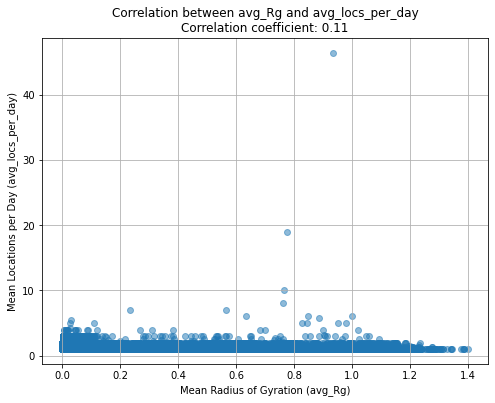

Correlation coefficient between avg_Rg and avg_locs_per_day: 0.11
Correlation plot saved to: /home/emmmanuel/Documents/correlation_plot.png


In [37]:
# Define the path to save the correlation plot
output_plot_path = '/home/emmmanuel/Documents/correlation_plot.png'  # Replace with your desired output path

# Plot the correlation between avg_Rg and avg_locs_per_day and save the plot
plot_correlation(user_mobility_rg_df, output_plot_path)

In [38]:
spark.stop()

## Task-4. What large dataset challenges did you face and how did you solve them.

 - Working with the large dataset (simulated_cdrs) presented several challenges, particularly in terms of memory limitations, processing time, and data quality. One of the main issues I faced was system memory constraints. When attempting to process the entire dataset in Spark, I encountered frequent memory-related errors, such as OutOfMemoryError. To address this, I configured Spark to allocate smaller amounts of memory to the driver and executor using settings like spark.executor.memory and spark.driver.memory. Additionally, I enabled disk-based storage for intermediate data to manage memory usage during shuffles and joins. This allowed the process to run smoothly without crashing.

 - Another challenge was the long processing time, especially during debugging and testing. Iterating through the entire dataset repeatedly was inefficient, so I implemented data sampling during the preprocessing step. I sampled a subset of users (e.g., 100 users) for testing and debugging, which allowed me to quickly verify the code before scaling up to the full dataset. This approach significantly reduced the time spent on debugging and ensured that the workflow was correct.

 - I also encountered issues with Spark’s schema inference, as it failed to correctly interpret the data types in the raw CSV files. To resolve this, I explicitly defined the schema for the raw data, ensuring that columns like cdrDatetime were correctly parsed as timestamps. Additionally, I enabled Spark’s legacy time parser policy to handle the datetime format in the dataset, which prevented errors during preprocessing.

 - Data quality was another concern, as the dataset contained missing or invalid values, such as null cdrDatetime or cellId entries. I addressed this by dropping rows with missing critical columns and filling in missing values with defaults where appropriate. Finally, to manage large output files, I saved the preprocessed data and user attributes in a compressed format like Parquet, which reduced file size and improved write performance.

Overall, were critical to overcoming the challenges of working with a large dataset on my local machine. They allowed me to efficiently process the data and generate accurate results while staying within system limitations